<a href="https://colab.research.google.com/github/cppel/data/blob/main/5_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%965_%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B9_%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%BE%D0%B2_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №5. Создание простой рекомендательной системы на основе алгоритмов кластеризации

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
colab = True  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
if colab:
    anime = pd.read_csv('/content/drive/MyDrive/task2/anime.csv', index_col='anime_id')
else:
    anime = pd.read_csv('../kekzawr/anime/anime.csv', index_col='anime_id')
all_anime = anime.copy()
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [27]:
if colab:
    ratings = pd.read_csv('/content/drive/MyDrive/task2/rating.csv')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет.

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут.

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее.

### 1. Избавьтесь от -1

In [28]:
ratings = ratings[(ratings['rating'] != 0) & (ratings['rating'] != -1)]

In [29]:
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Критерий Шавене (Chauvenet)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn.

In [30]:
from scipy.special import erfc
def chauvenet(data):
    n = len(data)
    mean_P = np.mean(data)
    Sp = np.std(data)
    Pi = np.abs(data - mean_P) / Sp
    prob = erfc(Pi)
    threshold = 1 / (2 * n)
    mask = prob < threshold
    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [31]:
count_reviews = ratings.groupby('user_id')['anime_id'].count().reset_index()
count_reviews.columns = ['user_id', 'how_many_anime_watched']
count_reviews

,user_id,how_many_anime_watched
0,1,4
1,2,1
2,3,92
3,5,459
4,7,343
...,...,...
69595,73512,12
69596,73513,33
69597,73514,1
69598,73515,179


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [32]:
outlier_users = chauvenet(count_reviews['how_many_anime_watched'].values)
outliers = count_reviews[outlier_users]
outliers

,user_id,how_many_anime_watched
214,226,742
256,271,599
277,294,675
369,392,598
419,446,743
...,...,...
69446,73356,565
69452,73362,596
69468,73378,723
69485,73395,585


(0.0, 4000.0)

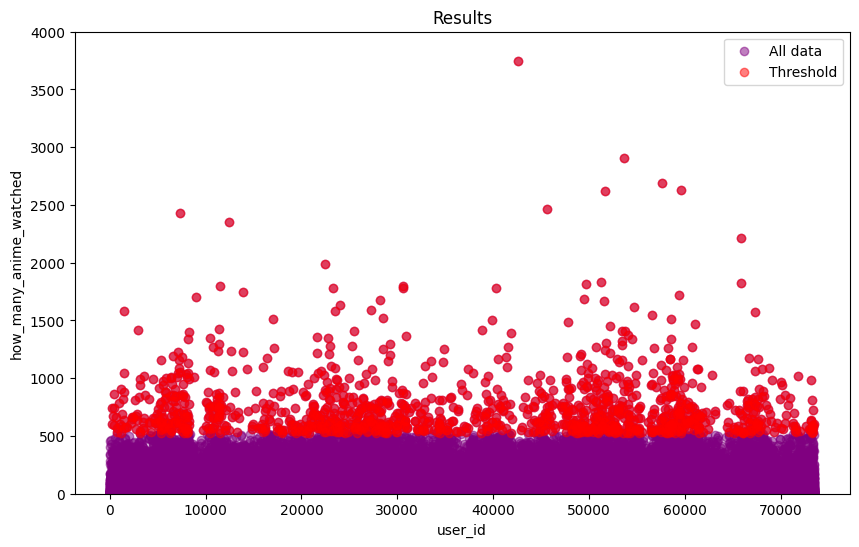

In [33]:
plt.figure(figsize=(10, 6))
#График count_reviews, c кол-вом аниме просмотренных пользователями
plt.scatter(
    count_reviews['user_id'].values,
    count_reviews['how_many_anime_watched'].values,
    alpha=0.5,
    color='purple',
    label='All data'
)

#График outliers, c кол-вом выбросов в графике count_reviews
plt.scatter(
    outliers['user_id'].values,
    outliers['how_many_anime_watched'].values,
    alpha=0.5,
    color='red',
    label='Threshold'
)

plt.title('Results')
plt.xlabel('user_id')
plt.ylabel('how_many_anime_watched')
plt.legend()
plt.ylim(0, 4000)

### 5. Ответьте на вопросы

#### 1. Кого критерий посчитал выбросом?

#### 2. Почему критерий посчитал их выбросом?

#### 3. Нужна ли им вообще рекомендательная система?


**Ответы:**

1. Критерий оказался выбросом в том случае если оно больше 500 к примеру;
2. Потому что значения кол-ва просмотренных аниме у этих пользователей сильно отличаются от среднего значения и стандартного отклонения общего кол-ва просмотренных аниме;
3. Зависит от людей т.к. кто-то постоянно хочет смотреть что-то новое, кто-то наоборот консервативен и не имеет спонтанного интереса смотреть что-то новое из предложений рекомендательной системы, с другой стороны формально она нужна т.к. рекомендация новой аниме несмотря на большое количество просмотренных будет лучше если такого предложения вообще нет.

In [34]:
bad_user_threshold = outliers['how_many_anime_watched'].min()
bad_user_threshold

522

Если все было правильно `bad_user_threshold` больше 500.

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [35]:
count_reviews = count_reviews.rename(columns={'how_many_anime_watched': 'count_reviews'})
merged_data = ratings.merge(count_reviews, on='user_id', how='inner')
ratings = merged_data[merged_data['count_reviews'] < bad_user_threshold]
ratings

,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1
...,...,...,...,...
6337236,73515,16512,7,179
6337237,73515,17187,9,179
6337238,73515,22145,10,179
6337239,73516,790,9,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [36]:
median = ratings['count_reviews'].median()
ratings = ratings[ratings.count_reviews > median]
ratings

,user_id,anime_id,rating,count_reviews
97,5,6,8,459
98,5,15,6,459
99,5,17,6,459
100,5,18,6,459
101,5,20,6,459
...,...,...,...,...
6337234,73515,13659,8,179
6337235,73515,14345,7,179
6337236,73515,16512,7,179
6337237,73515,17187,9,179


In [37]:
ratings = ratings.drop(columns=['count_reviews'])
ratings

,user_id,anime_id,rating
97,5,6,8
98,5,15,6
99,5,17,6
100,5,18,6
101,5,20,6
...,...,...,...
6337234,73515,13659,8
6337235,73515,14345,7
6337236,73515,16512,7
6337237,73515,17187,9


Теперь рассмотрим таблицу `anime`.


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [38]:
outlier_anime = anime[chauvenet(anime['rating'].values)]
outlier_anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
2792,Panzer Dragoon,"Adventure, Fantasy",OVA,1,3.47,1047
11883,Nendo no Tatakai 2,"Comedy, Fantasy",ONA,1,3.46,1042
29617,Good-by Elvis and USA,"Dementia, Music",Movie,1,3.41,367
11897,Nendo no Tatakai,"Comedy, Fantasy",ONA,1,3.36,1174
32894,Love Bites,Horror,ONA,1,3.33,537
...,...,...,...,...,...,...
20007,Hi Gekiga Ukiyoe Senya Ichiya,"Action, Hentai",Movie,1,1.92,129
17825,Ikenai Boy: Ikasu Maruhi Hand Power,"Comedy, Hentai",OVA,1,3.11,112
23677,Manga Edo Erobanashi,"Comedy, Hentai, Historical",OVA,5,2.86,111


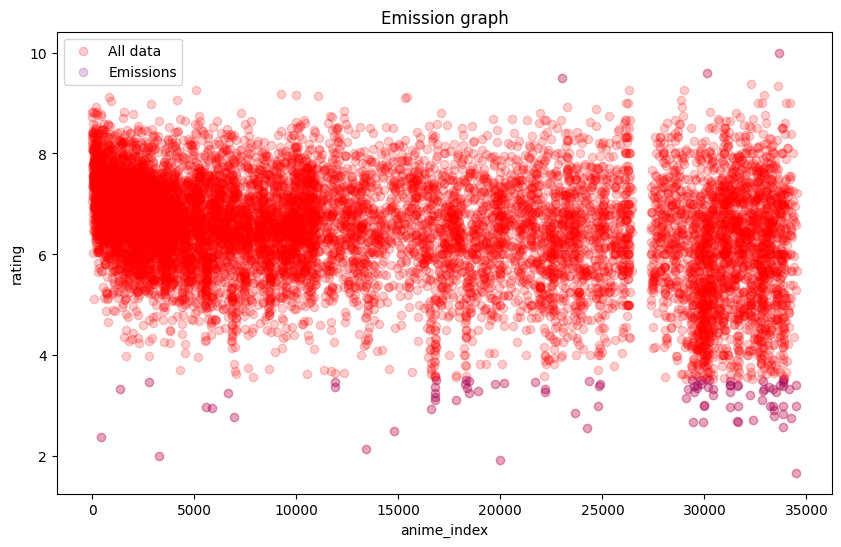

In [41]:
plt.figure(figsize=(10, 6))

#График count_reviews, c кол-вом аниме просмотренных пользователями
plt.scatter(
    anime['name'].index,
    anime['rating'],
    alpha=0.2,
    color='red',
    label='All data'
)

#График outliers, c кол-вом выбросов в графике count_reviews
plt.scatter(
    outlier_anime['name'].index,
    outlier_anime['rating'],
    alpha=0.2,
    color='purple',
    label='Emissions'
)

plt.title('Emission graph')
plt.xlabel('anime_index')
plt.ylabel('rating')
plt.legend()

### 9. Ответье на вопросы

#### 1. Что критерий посчитал выбросом?

#### 2. Почему критерий посчитал их выбросом?

#### 3. Можем ли мы как то использовать эти аниме в нашей рекомендательное системе?

**Ответы:**

1. За выбросы посчитались аниме с рейтингом примерно 3.8 и меньше , а также аниме с рейтингом 9.4 и выше.
2. Относительно средней оценки, которую пользователи сформировали, будут являться выбросами.
3. Скорее всего использовать аниме с наилучшим рейтингом т.е. более 9, иначе те что ниже но считаются выбросами не предлагать пользователю

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы.

In [42]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. (flatten - уплощение списка списков в один список).
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [43]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']
len= 3229

Genres=['Martial Arts', 'Yaoi', 'Police', 'Samurai', 'Magic', 'Super Power', 'Romance', 'Psychological', 'Mystery', 'Josei', 'Hentai', 'Horror', 'Drama', 'Shounen Ai', 'School', 'Demons', 'Shoujo Ai', 'Adventure', 'Dementia', 'Comedy', 'Sci-Fi', 'Yuri', 'Mecha', 'Thriller', 'Historical', 'Vampire', 'Ecchi', 'Space', 'Slice of Life', 'Parody', 'Shounen', 'Game', 'Military', 'Cars', 'Seinen', 'Harem', 'Sports', 'Shoujo', 'Supernatural', 'Music', 'Kids', 'Fantasy', 'Action']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [45]:
anime_genre = pd.DataFrame(columns=['name'] + genres)
anime_genre['name'] = anime['name']

for genre in genres:
    anime_genre[genre] = anime['genre'].str.contains(genre).astype(int)

anime_genre

,name,Martial Arts,Yaoi,Police,Samurai,Magic,Super Power,Romance,Psychological,Mystery,...,Cars,Seinen,Harem,Sports,Shoujo,Supernatural,Music,Kids,Fantasy,Action
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,Kimi no Na wa.,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,Fullmetal Alchemist: Brotherhood,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
28977,Gintama°,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9253,Steins;Gate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9969,Gintama&#039;,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,Under World,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,Violence Gekiga David no Hoshi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [46]:
df = pd.merge(anime_genre, ratings, on='anime_id')
df

,anime_id,name,Martial Arts,Yaoi,Police,Samurai,Magic,Super Power,Romance,Psychological,...,Harem,Sports,Shoujo,Supernatural,Music,Kids,Fantasy,Action,user_id,rating
0,32281,Kimi no Na wa.,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,244,10
1,32281,Kimi no Na wa.,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,462,8
2,32281,Kimi no Na wa.,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,548,10
3,32281,Kimi no Na wa.,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,598,10
4,32281,Kimi no Na wa.,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,784,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694976,5569,Tsui no Sora,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5204,1
2694977,5569,Tsui no Sora,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12233,1
2694978,5569,Tsui no Sora,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,41926,1
2694979,5569,Tsui no Sora,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,60576,4


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [47]:
genre_col = df.columns[1:45].values

for genre in genre_col:
    df[genre] = np.where(df[genre] == 1, df['rating'], df[genre])
df.replace(0, np.nan, inplace=True)

genre_avg_ratings = df.groupby('user_id')[genre_col].mean()
genre_avg_ratings

<ipython-input-47-915e47f264ca>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_avg_ratings = df.groupby('user_id')[genre_col].mean()


,Martial Arts,Yaoi,Police,Samurai,Magic,Super Power,Romance,Psychological,Mystery,Josei,...,Cars,Seinen,Harem,Sports,Shoujo,Supernatural,Music,Kids,Fantasy,Action
user_id,,,,,,,,,,,,,,,,,,,,,
5,4.115385,NaN,2.500000,7.166667,4.058824,4.170732,2.993506,4.142857,4.040000,7.000000,...,6.0,4.210526,2.217949,6.000000,2.750000,4.346939,4.727273,5.555556,4.410526,4.701299
7,7.166667,NaN,7.500000,6.000000,7.690476,7.939394,7.146154,8.333333,7.923077,NaN,...,NaN,7.259259,7.111111,7.333333,7.642857,7.631579,6.571429,8.500000,7.337209,7.484127
17,7.000000,NaN,7.600000,7.500000,7.193548,6.900000,6.968421,7.522727,7.156863,9.000000,...,8.0,6.779661,6.433333,7.444444,6.100000,7.376238,7.083333,6.500000,6.973684,7.027211
21,7.666667,NaN,9.000000,7.000000,7.214286,7.769231,7.600000,8.423077,8.000000,8.000000,...,6.5,7.769231,7.222222,7.200000,7.000000,7.740741,7.833333,7.000000,7.348837,7.516129
38,5.142857,NaN,6.000000,6.666667,7.280000,7.175000,5.535714,8.277778,7.648649,4.000000,...,NaN,6.648649,4.212121,8.250000,3.000000,6.969072,6.666667,NaN,6.883333,6.925714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,8.000000,NaN,7.285714,6.500000,5.222222,7.000000,6.850000,7.285714,7.525000,7.750000,...,9.0,8.125000,5.500000,8.500000,7.250000,7.204082,7.500000,4.333333,7.170732,7.310345
73502,8.214286,NaN,9.000000,6.333333,8.650000,9.129032,8.445055,9.250000,9.101695,9.181818,...,9.0,8.763636,8.000000,7.727273,8.777778,8.894309,8.833333,6.000000,8.602740,8.658228
73503,5.500000,NaN,8.000000,6.333333,5.714286,6.428571,6.507463,7.064516,7.204082,6.750000,...,NaN,6.892857,4.700000,5.500000,6.214286,6.489796,8.500000,NaN,6.022472,6.389610


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [48]:
genre_avg_ratings.fillna(-1, inplace=True)

In [49]:
genre_avg_ratings

,Martial Arts,Yaoi,Police,Samurai,Magic,Super Power,Romance,Psychological,Mystery,Josei,...,Cars,Seinen,Harem,Sports,Shoujo,Supernatural,Music,Kids,Fantasy,Action
user_id,,,,,,,,,,,,,,,,,,,,,
5,4.115385,-1.0,2.500000,7.166667,4.058824,4.170732,2.993506,4.142857,4.040000,7.000000,...,6.0,4.210526,2.217949,6.000000,2.750000,4.346939,4.727273,5.555556,4.410526,4.701299
7,7.166667,-1.0,7.500000,6.000000,7.690476,7.939394,7.146154,8.333333,7.923077,-1.000000,...,-1.0,7.259259,7.111111,7.333333,7.642857,7.631579,6.571429,8.500000,7.337209,7.484127
17,7.000000,-1.0,7.600000,7.500000,7.193548,6.900000,6.968421,7.522727,7.156863,9.000000,...,8.0,6.779661,6.433333,7.444444,6.100000,7.376238,7.083333,6.500000,6.973684,7.027211
21,7.666667,-1.0,9.000000,7.000000,7.214286,7.769231,7.600000,8.423077,8.000000,8.000000,...,6.5,7.769231,7.222222,7.200000,7.000000,7.740741,7.833333,7.000000,7.348837,7.516129
38,5.142857,-1.0,6.000000,6.666667,7.280000,7.175000,5.535714,8.277778,7.648649,4.000000,...,-1.0,6.648649,4.212121,8.250000,3.000000,6.969072,6.666667,-1.000000,6.883333,6.925714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,8.000000,-1.0,7.285714,6.500000,5.222222,7.000000,6.850000,7.285714,7.525000,7.750000,...,9.0,8.125000,5.500000,8.500000,7.250000,7.204082,7.500000,4.333333,7.170732,7.310345
73502,8.214286,-1.0,9.000000,6.333333,8.650000,9.129032,8.445055,9.250000,9.101695,9.181818,...,9.0,8.763636,8.000000,7.727273,8.777778,8.894309,8.833333,6.000000,8.602740,8.658228
73503,5.500000,-1.0,8.000000,6.333333,5.714286,6.428571,6.507463,7.064516,7.204082,6.750000,...,-1.0,6.892857,4.700000,5.500000,6.214286,6.489796,8.500000,-1.000000,6.022472,6.389610


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
norm_genre_avg_ratings = scaler.fit_transform(genre_avg_ratings[genres])

norm_genre_avg_ratings

array([[0.46503497, 0.        , 0.31818182, ..., 0.5959596 , 0.37894737,
        0.51829988],
       [0.74242424, 0.        , 0.77272727, ..., 0.86363636, 0.70413437,
        0.77128427],
       [0.72727273, 0.        , 0.78181818, ..., 0.68181818, 0.66374269,
        0.72974644],
       ...,
       [0.59090909, 0.        , 0.81818182, ..., 0.        , 0.55805243,
        0.67178276],
       [0.86363636, 0.        , 0.86363636, ..., 0.        , 0.72698413,
        0.8019802 ],
       [0.90909091, 0.        , 0.93939394, ..., 0.        , 0.85606061,
        0.88026608]])

### 15.Натренируйте kMeans с 10 кластерами на полученных данных

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(norm_genre_avg_ratings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

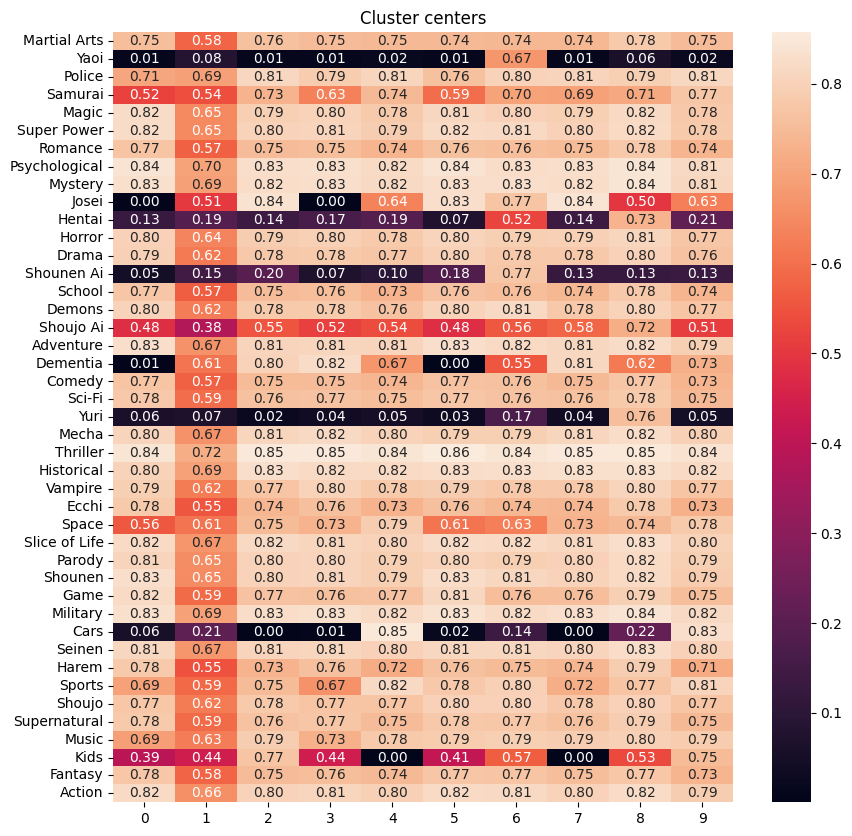

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_centers = kmeans.cluster_centers_

cluster_centers_df = pd.DataFrame(cluster_centers, columns=genres)


plt.figure(figsize=(10, 10))
sns.heatmap(cluster_centers_df.T, annot=True, fmt=".2f")
plt.title("Cluster centers")
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/29 [00:00<00:16,  1.70it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/29 [00:04<01:07,  2.51s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|█         | 3/29 [00:09<01:36,  3.71s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

Text(0, 0.5, '$J(C_k)$')

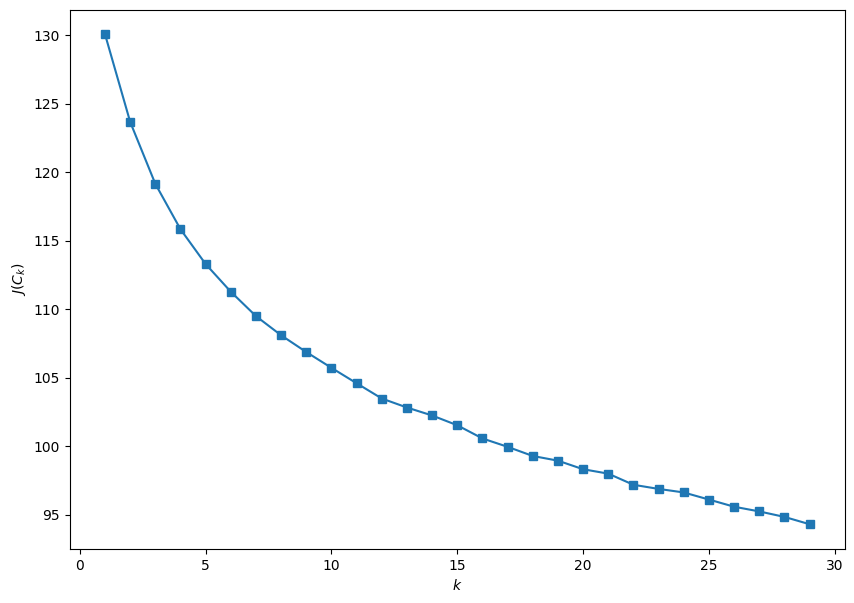

In [53]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(norm_genre_avg_ratings))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [54]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  4%|▎         | 1/28 [00:05<02:30,  5.58s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/28 [00:08<01:40,  3.88s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█         | 3/28 [00:10<01:23,  3.32s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

2

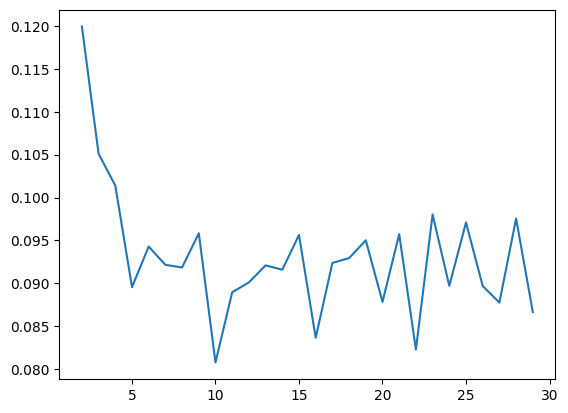

In [55]:
draw_sil_score(scaler.fit_transform(norm_genre_avg_ratings), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

In [56]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(norm_genre_avg_ratings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


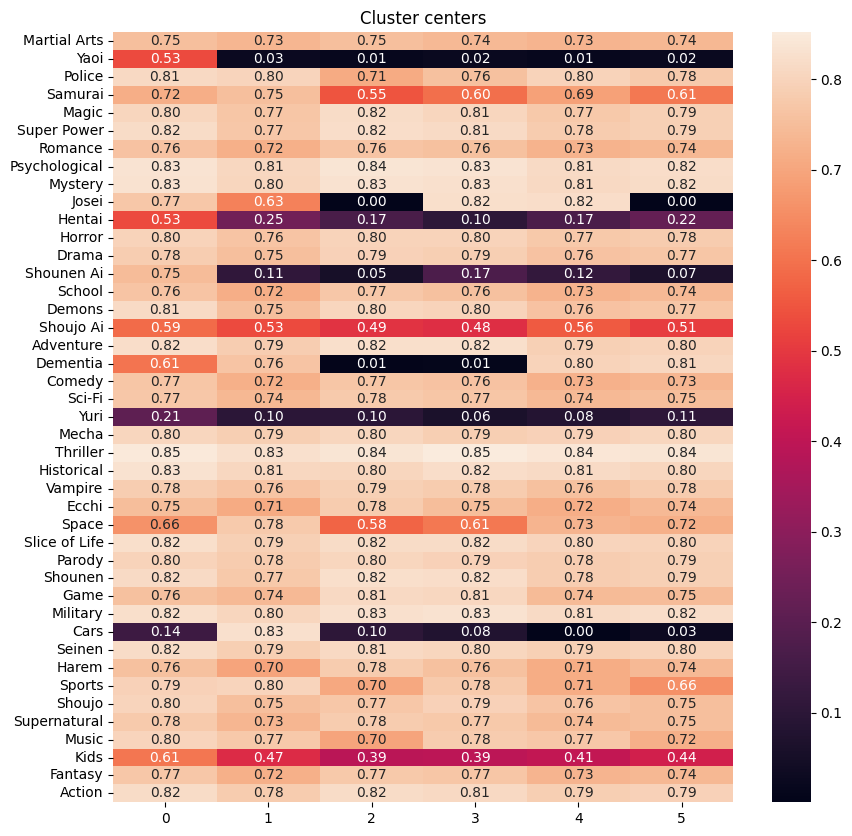

In [57]:
cluster_centers = kmeans.cluster_centers_

cluster_centers_df = pd.DataFrame(cluster_centers, columns=genres)

plt.figure(figsize=(10, 10))
sns.heatmap(cluster_centers_df.T, annot=True, fmt=".2f")
plt.title("Cluster centers")
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю.
Это можно сделать разными способами. Как это сделать подумайте сами.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен.
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [58]:
recomended_genres = {}

for cluster in range(len(cluster_centers_df)):
    cluster_center = cluster_centers_df.iloc[cluster]
    sorted_genre_index = cluster_center.argsort()[::-1]
    sorted_genres = cluster_centers_df.columns[sorted_genre_index]
    recomended_genres[cluster] = sorted_genres

recomended_genres

{0: Index(['Thriller', 'Psychological', 'Mystery', 'Historical', 'Military',
        'Slice of Life', 'Adventure', 'Super Power', 'Action', 'Seinen',
        'Shounen', 'Demons', 'Police', 'Magic', 'Mecha', 'Shoujo', 'Music',
        'Parody', 'Horror', 'Sports', 'Drama', 'Vampire', 'Supernatural',
        'Fantasy', 'Sci-Fi', 'Josei', 'Comedy', 'School', 'Romance', 'Game',
        'Harem', 'Martial Arts', 'Ecchi', 'Shounen Ai', 'Samurai', 'Space',
        'Kids', 'Dementia', 'Shoujo Ai', 'Yaoi', 'Hentai', 'Yuri', 'Cars'],
       dtype='object'),
 1: Index(['Cars', 'Thriller', 'Historical', 'Psychological', 'Military',
        'Mystery', 'Police', 'Sports', 'Slice of Life', 'Seinen', 'Mecha',
        'Adventure', 'Parody', 'Action', 'Space', 'Shounen', 'Music',
        'Super Power', 'Magic', 'Dementia', 'Horror', 'Vampire', 'Shoujo',
        'Samurai', 'Drama', 'Demons', 'Game', 'Sci-Fi', 'Martial Arts',
        'Supernatural', 'Fantasy', 'Romance', 'Comedy', 'School', 'Ecchi',
      